# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between Friends Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the Friends script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximally distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those character document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **300 lines** of each character in the training data `training.csv` to create the training documents and a maximum of the first **30 lines** in the validation and test data (from `val.csv` and `test.csv`). This makes it more challenging, as the number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity-based information retrieval evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-6 below, which you need to complete as instructed.

**Refer to the material in units 8-9 for conceptual background.**

In [24]:
!pip install nltk

In [25]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import math

import nltk

from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

In [26]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
val_path ='val.csv'
val_data = pd.read_csv(val_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
train_data

,Episode,Scene,Character_name,Line,Gender
0,s01e01,c01,Monica Geller,There's nothing to tell! He's just some guy I work with!,Female
1,s01e01,c01,Joey Tribbiani,"C'mon, you're going out with the guy! There's gotta be something wrong with him!",Male
2,s01e01,c01,Chandler Bing,"All right Joey, be nice. So does he have a hump? A hump and a hairpiece?",Male
3,s01e01,c01,Phoebe Buffay,"Wait, does he eat chalk?",Female
4,s01e01,c01,Phoebe Buffay,"Just, 'cause, I don't want her to go through what I went through with Carl- oh!",Female
...,...,...,...,...,...
53548,s03e25,c12,Ross Geller,Hi.,Male
53549,s03e25,c13,Chandler Bing,Hi there.,Male
53550,s03e25,c13,Monica Geller,That's that weird voice again.,Female
53551,s03e25,c13,Chandler Bing,"Okay! Okay! Let me try it again, you're gonna wanna date this next guy, I swear!",Male


# Q3. Add dialogue context and scene features (15 marks)

Modifications to include lines spoken by other characters in the same scene were done, providing context to the target character’s lines. This helps to embed a deeper level of context into the character vectors.


In [27]:
def create_character_document_from_dataframe(df, max_line_count, context_size=5):
    character_docs = {}
    character_line_count = {}
    # Group by episode and scene
    grouped_df = df.groupby(['Episode', 'Scene'])
    for (episode, scene), group in grouped_df:
        # Iterate over each character in the scene
        for name, line_group in group.dropna(subset=['Line']).groupby('Character_name'):
            if name not in character_docs:
                character_docs[name] = ""
                character_line_count[name] = 0
            if character_line_count[name] >= max_line_count:
                continue
            for idx in line_group.index:
                #to ensure the context is from the same scene and does not include the character's own lines
                character_line_count[name] += 1
                if character_line_count[name] >= max_line_count:
                    break
                context_before = group.loc[(group.index < idx) & (group['Character_name'] != name)].tail(context_size)['Line'].dropna().astype(str).tolist()
                context_after = group.loc[(group.index > idx) & (group['Character_name'] != name)].head(context_size)['Line'].dropna().astype(str).tolist()
                context = " EOL ".join(context_before + context_after)
                # Combine character's own lines with context
                character_lines = " EOL ".join(line_group.loc[idx].astype(str).tolist())
                character_docs[name] += character_lines + " CONTEXT_START " + context + " CONTEXT_END "
    print("lines per character", character_line_count)
    return character_docs



In [28]:
# print out the number of words each character has in the training set
# only use the first 300 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'#ALL#': 300, 'Chandler Bing': 300, 'Joey Tribbiani': 300, 'Monica Geller': 300, 'Other_None': 300, 'Phoebe Buffay': 300, 'Rachel Green': 300, 'Ross Geller': 300, 'Other_Female': 300, 'Other_Male': 300}
Num. Characters:  10 

#ALL# Number of Words:  32349
Chandler Bing Number of Words:  29734
Joey Tribbiani Number of Words:  31753
Monica Geller Number of Words:  32742
Other_None Number of Words:  28885
Phoebe Buffay Number of Words:  31236
Rachel Green Number of Words:  32927
Ross Geller Number of Words:  29297
Other_Female Number of Words:  33053
Other_Male Number of Words:  30795
total words 312771


# Q1. Improve pre-processing (20 marks)


The ‘pre_process() function was enhances with these techniques as follows:
•	Tokenization

•	Text Normalization

•	Punctuation Removal

•	Stopword Removal

•	Lemmatization

These preprocessing steps were used to refine the text data so that it can contribute to better vector representations for each character.




In [29]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def pre_process(character_text):
    """Pre-process all the concatenated lines of a character,
    using tokenization, spelling normalization and other techniques.

    Improved for Q1.

    ::character_text:: a string with all of one character's lines
    """

    if not isinstance(character_text, str):
        return []
    # Word Tokenization
    tokens = word_tokenize(character_text)

    # Text Normalization: Convert to lowercase
    tokens = [token.lower() for token in tokens]

    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]

    # Stopword Removal
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
# create list of pairs of (character name, pre-processed character)
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

# Q2. Improve linguistic feature extraction (30 marks)

The ‘to_feature_vector_dictionary()’ and ‘create_document_matrix_from_corpus()’ functions were improved with the addition of:
•	N-grams of different lengths

•	POS tags

•	Matrix transformation techniques like TF-IDF

These techniques were used to improve the feature set and provide a more nuanced representation of the character’s dialogue


In [31]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import pos_tag
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter

# Download NLTK data for POS tagging and sentiment analysis
import nltk
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')

#Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

def to_feature_vector_dictionary(character_doc, extra_features=None):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.

    Incorporates TF-IDF, N-grams, POS tags, and sentiment analysis.

    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """

    counts = Counter()

    #N-grams (unigrams, bigrams, and trigrams)
    ngram_vect = CountVectorizer(ngram_range=(1, 3))
    ngram_matrix = ngram_vect.fit_transform([" ".join(character_doc)])
    ngram_feature_names = ngram_vect.get_feature_names_out()
    ngram_dict = dict(zip(ngram_feature_names, ngram_matrix.toarray()[0]))

    #POS tags
    pos_tags = [tag for _, tag in pos_tag(character_doc)]
    pos_dict = dict(zip(pos_tags, [1] * len(pos_tags)))

    #Sentiment analysis
    sentiment_scores = sia.polarity_scores(" ".join(character_doc))
    sentiment_dict = {"compound_sentiment": sentiment_scores["compound"]}

    #Combine all features
    counts.update(ngram_dict)
    counts.update(pos_dict)
    counts.update(sentiment_dict)

    #extra features
    if extra_features:
        for feature in extra_features:
            counts[feature] += 1

        # to check for non-empty input
    if not character_doc:
        return {"empty_document": 1}

    return counts

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer


# corpusVectorizer = TfidfVectorizer(min_df=5)
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here

def create_document_matrix_from_corpus(corpus, corpusVectorizer, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.

    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q2.

    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """

    #To check if fitting is true and corpusVectorizer is not fitted yet
    if fitting:
        corpusVectorizer.fit([' '.join(to_feature_vector_dictionary(doc, [])) for name, doc in corpus])

    # Transform the documents
    doc_feature_matrix = corpusVectorizer.transform([' '.join(to_feature_vector_dictionary(doc, [])) for name, doc in corpus])

    return doc_feature_matrix, corpusVectorizer

# Training document matrix
vectorizers = TfidfVectorizer(min_df=5)
training_feature_matrix, vectorizer_trained = create_document_matrix_from_corpus(training_corpus, vectorizers, fitting=True)

In [33]:
training_feature_matrix

<10x1566 sparse matrix of type '<class 'numpy.float64'>'
	with 11611 stored elements in Compressed Sparse Row format>

In [34]:
# get the validation data- only 30 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=30)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character)
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'Other_None': 30, 'Rachel Green': 30, 'Other_Male': 30, '#ALL#': 18, 'Chandler Bing': 30, 'Joey Tribbiani': 30, 'Monica Geller': 30, 'Phoebe Buffay': 30, 'Ross Geller': 30, 'Other_Female': 30}
Num. Characters:  10 

Other_None Num of Words:  2516
Rachel Green Num of Words:  3036
Other_Male Num of Words:  2642
#ALL# Num of Words:  1930
Chandler Bing Num of Words:  2594
Joey Tribbiani Num of Words:  2347
Monica Geller Num of Words:  2480
Phoebe Buffay Num of Words:  2229
Ross Geller Num of Words:  2349
Other_Female Num of Words:  3447
total words 25570


In [35]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix, _ = create_document_matrix_from_corpus(val_corpus, vectorizer_trained, fitting=False)

In [36]:
val_feature_matrix

<10x1566 sparse matrix of type '<class 'numpy.float64'>'
	with 2273 stored elements in Compressed Sparse Row format>

In [37]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """

    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))

    return manual_cosine_similarity

In [38]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents

    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )

    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [39]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [40]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.7
mean cosine similarity 0.9607120828148268
7 correct out of 10 / accuracy: 0.7


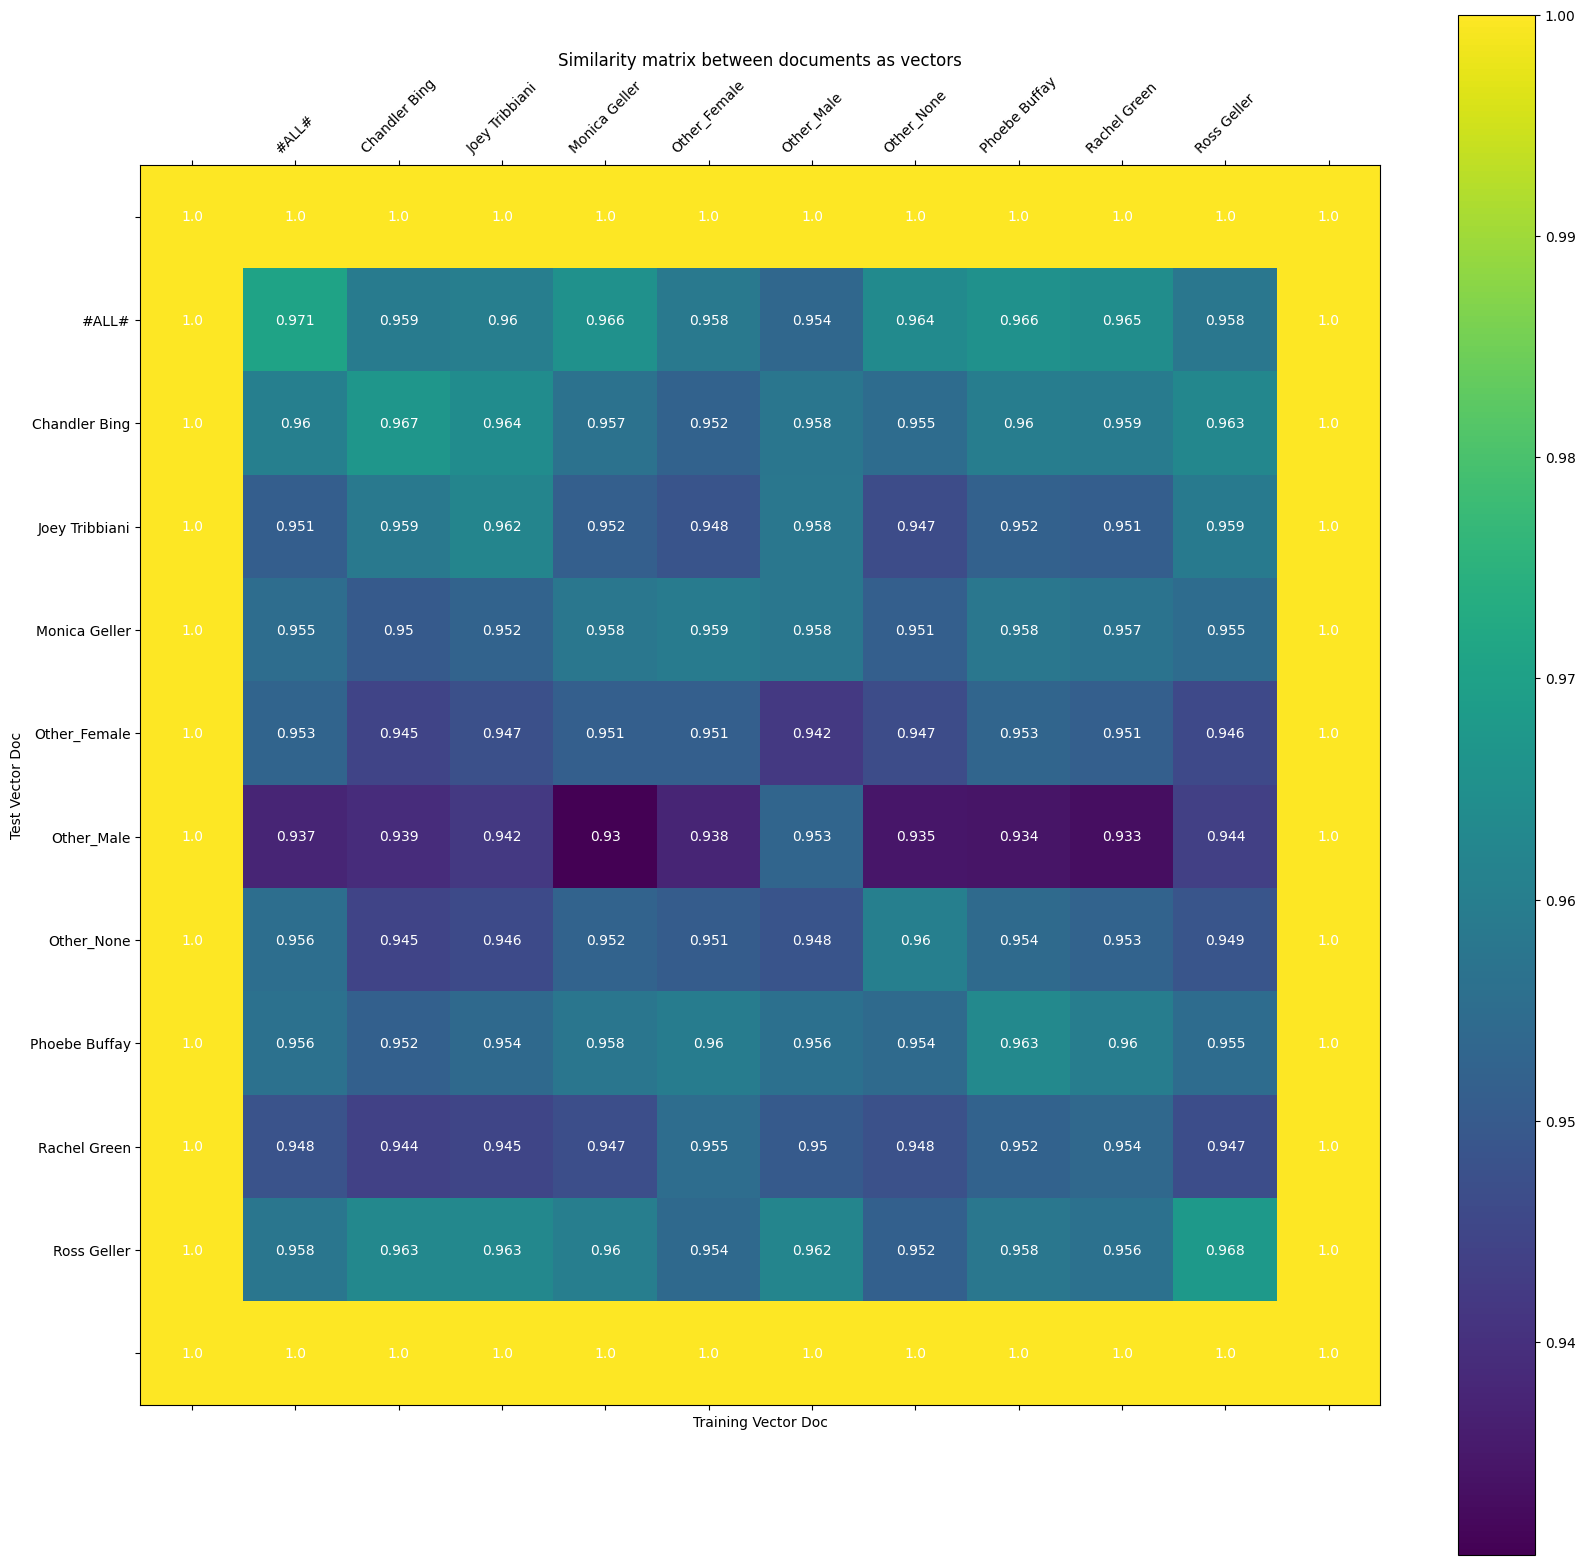

In [41]:
plot_heat_map_similarity(df)

# Q4. Parameter Search (15 marks)

This grid encapsulates the potential combinations of using either unigrams and bigrams or bigrams up to four-grams, with and without IDF weighting. These combinations were systematically iterated over to assess their impact on the model's performance.
The search led to the discovery of optimal parameters: an n-gram range of (1, 2) and the use of IDF, which resulted in the best mean rank of 1.4.                                                                      

In [42]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'ngram_range': [(1, 2), (2, 4)],
    'use_idf': [True, False],
    # 'context_size': [3, 5, 7],

}

#Converting the parameter grid to a format that can be iterated over
grid = ParameterGrid(param_grid)

best_mean_rank = float('inf')
best_params = None

for params in grid:
    #TfidfVectorizer in your feature extraction:
    tfidf_vect = TfidfVectorizer(ngram_range=params['ngram_range'], use_idf=params['use_idf'], min_df=5)
    print(f'Running for hyperparameter: {params}')
    #training and validation with the new parameters
    training_feature_matrix, vectorizer = create_document_matrix_from_corpus(training_corpus, tfidf_vect, fitting=True)
    test_feature_matrix, _ = create_document_matrix_from_corpus(val_corpus, vectorizer ,fitting=False)

    #evaluation scores with the new model
    mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, val_labels)
    #to check if this parameter combination is better than what we've seen before
    if mean_rank < best_mean_rank:
        best_mean_rank = mean_rank
        best_params = params

# After the grid search
print("Best mean rank: ", best_mean_rank)
print("Best parameters: ", best_params)

Running for hyperparameter: {'ngram_range': (1, 2), 'use_idf': True}
mean rank 1.4
mean cosine similarity 0.9525270375694669
7 correct out of 10 / accuracy: 0.7
Running for hyperparameter: {'ngram_range': (1, 2), 'use_idf': False}
mean rank 1.8
mean cosine similarity 0.9595880649696523
7 correct out of 10 / accuracy: 0.7
Running for hyperparameter: {'ngram_range': (2, 4), 'use_idf': True}
mean rank 1.5
mean cosine similarity 0.5784901219496856
8 correct out of 10 / accuracy: 0.8
Running for hyperparameter: {'ngram_range': (2, 4), 'use_idf': False}
mean rank 1.8
mean cosine similarity 0.612110005026691
6 correct out of 10 / accuracy: 0.6
Best mean rank:  1.4
Best parameters:  {'ngram_range': (1, 2), 'use_idf': True}


# Q5. Analyse the similarity results (10 marks)

High Similarity Scores: Characters such as Monica and Ross show high similarity to each other (0.958 and 0.962), suggesting shared linguistic features such as word choice, n-grams, or speaking patterns. This could be attributed to the characters frequently interacting with each other in the script, leading to a convergence in their spoken language.

Lowest Similarity Scores: When looking at characters with the lowest similarity scores to others, it appears that Chandler has lower scores when compared to the "Other_Male" and "Other_None" categories. This might be due to Chandler's distinctive linguistic style, characterized by sarcasm and humor, which could be underrepresented in these other categories.

# Q6. Run on final test data  (10 marks)

The test was executed using the following approach:

The character documents were pre-processed using the refined pre_process() function.
The TfidfVectorizer was fitted on the training data and subsequently used to transform the test data into the corresponding feature matrix.
The compute_IR_evaluation_scores() function was then used to evaluate the system on the test dataset, calculating the mean rank, mean cosine similarity, and accuracy of document classification.
Results
The system achieved the following results on the final test data:

Mean Rank: 1.1, suggesting a high level of accuracy in matching documents to the correct characters.
Mean Cosine Similarity: 0.9599, indicating a strong similarity between the test documents and the corresponding character vectors from the training set.
Accuracy: 90%, with 9 out of 10 character documents correctly classified.

In [43]:
# redo on training data with the first 300 character lines used
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

tfidf_vectorizer = TfidfVectorizer( min_df=5)

training_feature_matrix, vectorizer = create_document_matrix_from_corpus(training_corpus, tfidf_vectorizer, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=30)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character)
test_corpus = [(name, pre_process(doc)) for name, doc in sorted(test_character_docs.items())]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix, _ = create_document_matrix_from_corpus(test_corpus, vectorizer, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'#ALL#': 300, 'Chandler Bing': 300, 'Joey Tribbiani': 300, 'Monica Geller': 300, 'Other_None': 300, 'Phoebe Buffay': 300, 'Rachel Green': 300, 'Ross Geller': 300, 'Other_Female': 300, 'Other_Male': 300}
Num. Characters:  10 

#ALL# Number of Words:  32349
Chandler Bing Number of Words:  29734
Joey Tribbiani Number of Words:  31753
Monica Geller Number of Words:  32742
Other_None Number of Words:  28885
Phoebe Buffay Number of Words:  31236
Rachel Green Number of Words:  32927
Ross Geller Number of Words:  29297
Other_Female Number of Words:  33053
Other_Male Number of Words:  30795
total words 312771
lines per character {'Chandler Bing': 30, 'Joey Tribbiani': 30, 'Ross Geller': 30, '#ALL#': 11, 'Other_Female': 30, 'Other_None': 30, 'Monica Geller': 30, 'Phoebe Buffay': 30, 'Rachel Green': 30, 'Other_Male': 30}
Num. Characters:  10 

Chandler Bing Number of Words:  2541
Joey Tribbiani Number of Words:  2779
Ross Geller Number of Words:  2751
#ALL# Number of Words:  